# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn-white')
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer

/tmp/ipykernel_1351726/397209899.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## User-Defined Functions

In [2]:
from Extract_DFM_Reanalysis_Data_Helper import generate_seed, init_random_generator
from Extract_DFM_Reanalysis_Data_Helper import get_data_file_names, downsample_data_files
from Extract_DFM_Reanalysis_Data_Helper import get_history_file_indices, get_datetime_for_data_files
from Extract_DFM_Reanalysis_Data_Helper import create_df_sampled_time, plot_sampled_datetime

from Extract_DFM_Reanalysis_Data_Helper import read_single_data_file, process_elevation_at_timestamp
from Extract_DFM_Reanalysis_Data_Helper import get_grid_indices_all, reconstruct_valid_grid_indices
from Extract_DFM_Reanalysis_Data_Helper import plot_contours_of_indices
from Extract_DFM_Reanalysis_Data_Helper import plot_contours_at_timestamp, plot_contours_at_timestamp2
from Extract_DFM_Reanalysis_Data_Helper import plot_pdf_at_timestamp

from Extract_DFM_Reanalysis_Data_Helper import sample_grid_indices
from Extract_DFM_Reanalysis_Data_Helper import plot_sampled_grid_points, plot_sampled_grid_points_3D
from Extract_DFM_Reanalysis_Data_Helper import create_time_grid_indices_map
from Extract_DFM_Reanalysis_Data_Helper import read_data_all_possible_times
from Extract_DFM_Reanalysis_Data_Helper import save_data_read_at_all_possible_times
from Extract_DFM_Reanalysis_Data_Helper import read_data_from_pickle_all_possible_times

# Global Start Time

In [3]:
global_start_time = timer()

# Variables to be used for extracting WRF data

In [4]:
# WRF data set location and the extracted data set location
data_files_location = '/p/vast1/climres/DFM_reanalysis'
extracted_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted'

# The current data set params
data_set_count = 0
percent_files_to_use = 0.010863484  # f1 = what percent of available files to use
#percent_files_to_use = 50.00  # f1 = what percent of available files to use
percent_grid_points_to_use = 0.01  # f2 = what percent of grid points to use
max_history_to_consider = 8 # n_history in hours
history_interval        = 2

In [5]:
data_set_name = 'dataset_%02d'%(data_set_count)
extracted_data_loc = os.path.join(extracted_data_base_loc, data_set_name)
os.system('mkdir -p %s'%extracted_data_loc)

collection_of_read_data_files = '{}_files_read.pkl'.format(data_set_name)
extracted_data_file_name = '{}_extracted.pkl'.format(data_set_name)

# Generate seed for the random number generator

In [6]:
seed = generate_seed()
random_state = init_random_generator(seed)

# File Names

In [7]:
module_start_time = timer()
data_files_list = get_data_file_names(data_files_location)
module_end_time = timer()
print('Module "get_data_file_names" computing time: {} s'.format(module_end_time - module_start_time))


Getting the names of the data files at the dir : 
 /p/vast1/climres/DFM_reanalysis 

years_list: ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'] 


Found a total of 184103 files 

Module "get_data_file_names" computing time: 3.718024487607181 s


## Deal with just first 100 files to check for correctness of script. Be sure to undo this

In [8]:
#data_files_list = data_files_list[0:30]

# Downsample Files

In [9]:
module_start_time = timer()
sampled_file_indices, sampled_data_files = downsample_data_files (data_files_list, percent_files_to_use, max_history_to_consider, random_state)
module_end_time = timer()
print('Module "downsample_data_files" computing time: {} s'.format(module_end_time - module_start_time))


Randomly selecting approx 0.010863484 % of the data files
Selected 20 data files out of 184103 total and 184095 usable considering historical data
Module "downsample_data_files" computing time: 0.06705289799720049 s


# Get History File Indices

In [10]:
module_start_time = timer()
history_file_indices = get_history_file_indices (sampled_file_indices, max_history_to_consider, history_interval)
module_end_time = timer()
print('Module "get_history_file_indices" computing time: {} s'.format(module_end_time - module_start_time))


Determining history file indices corresponding to sampled file/time indices...
Module "get_history_file_indices" computing time: 0.0011638989672064781 s


# Create timestamps and datetime of downsampled data files

In [11]:
module_start_time = timer()
sampled_time_stamps, sampled_datetime = get_datetime_for_data_files (sampled_data_files)
module_end_time = timer()
print('Module "get_datetime_for_data_files" computing time: {} s'.format(module_end_time - module_start_time))

Module "get_datetime_for_data_files" computing time: 0.0001359395682811737 s


# Create DataFrame using sampled file indices, filenames, timestamps, and datetime

In [12]:
module_start_time = timer()
df_sampled_time = create_df_sampled_time (sampled_file_indices, sampled_data_files, sampled_time_stamps, sampled_datetime, history_file_indices)
module_end_time = timer()
print('Module "create_df_sampled_time" computing time: {} s'.format(module_end_time - module_start_time))


Creating DataFrame using sampled file indices, filenames, timestamps, and datetime...
Module "create_df_sampled_time" computing time: 0.01665263157337904 s


In [13]:
#df_sampled_time[df_sampled_time['ref_time_indices'] < max_history_to_consider+10]

In [14]:
df_sampled_time.head(20)

,ref_time_indices,sampled_data_files,sampled_time_stamps,sampled_datetime,history_time_indices
0,53547,wrf_2006-02-09_03.nc,2006-02-09_03,2006-02-09 03:00:00,"[53539, 53541, 53543, 53545]"
1,175811,wrf_2020-01-21_12.nc,2020-01-21_12,2020-01-21 12:00:00,"[175803, 175805, 175807, 175809]"
2,140916,wrf_2016-01-28_13.nc,2016-01-28_13,2016-01-28 13:00:00,"[140908, 140910, 140912, 140914]"
3,88177,wrf_2010-01-22_01.nc,2010-01-22_01,2010-01-22 01:00:00,"[88169, 88171, 88173, 88175]"
4,16923,wrf_2001-12-06_03.nc,2001-12-06_03,2001-12-06 03:00:00,"[16915, 16917, 16919, 16921]"
5,123716,wrf_2014-02-10_21.nc,2014-02-10_21,2014-02-10 21:00:00,"[123708, 123710, 123712, 123714]"
6,178314,wrf_2020-05-04_19.nc,2020-05-04_19,2020-05-04 19:00:00,"[178306, 178308, 178310, 178312]"
7,28355,wrf_2003-03-27_11.nc,2003-03-27_11,2003-03-27 11:00:00,"[28347, 28349, 28351, 28353]"
8,1507,wrf_2000-03-03_19.nc,2000-03-03_19,2000-03-03 19:00:00,"[1499, 1501, 1503, 1505]"
9,26522,wrf_2003-01-10_02.nc,2003-01-10_02,2003-01-10 02:00:00,"[26514, 26516, 26518, 26520]"


# Plot Sampled Datetime


Plotting sampled datetime from the available data...


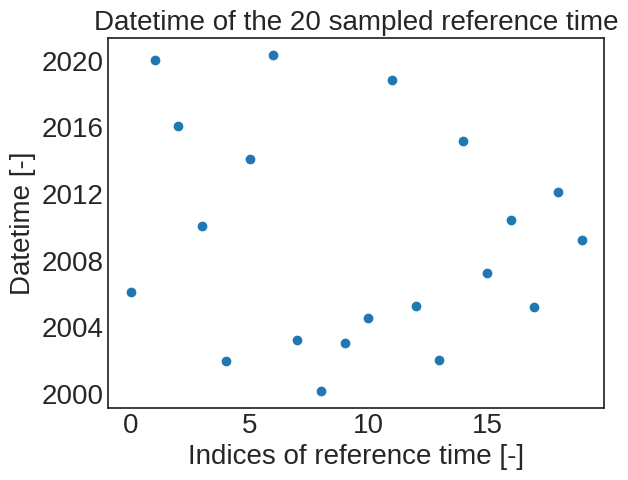

Module "plot_sampled_datetime" computing time: 0.8079231400042772 s


In [15]:
module_start_time = timer()
plot_sampled_datetime (df_sampled_time, extracted_data_loc)
module_end_time = timer()
print('Module "plot_sampled_datetime" computing time: {} s'.format(module_end_time - module_start_time))

# Read Quantities in a Selected Data File

## Read the Data in a Specified or Randomly Selected File

In [16]:
prescribe_file = True
if prescribe_file:
    data_file_to_read = 'wrf_2018-11-07_16.nc'
    timestamp_to_read = data_file_to_read.split('_')[1] + '_' + \
                        data_file_to_read.split('_')[2].split('.')[0]
else:
    random_ind_of_downsampled_files = random.choice(range(len(sampled_file_indices)))
    file_ind_to_read = sampled_file_indices[random_ind_of_downsampled_files]
    data_file_to_read = sampled_data_files[random_ind_of_downsampled_files]
    timestamp_to_read = sampled_time_stamps[random_ind_of_downsampled_files]

In [17]:
data_file_to_read, timestamp_to_read

('wrf_2018-11-07_16.nc', '2018-11-07_16')

In [18]:
module_start_time = timer()
data_at_timestamp = read_single_data_file (data_files_location, data_file_to_read, timestamp_to_read)
module_end_time = timer()
print('Module "read_single_data_file" computing time: {} s'.format(module_end_time - module_start_time))

Module "read_single_data_file" computing time: 4.95128371194005 s


## Processing Elevation Data into Pos, Neg, and Zero

In [19]:
module_start_time = timer()
data_at_timestamp = process_elevation_at_timestamp (data_at_timestamp)
module_end_time = timer()
print('Module "process_elevation_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

Module "process_elevation_at_timestamp" computing time: 0.003606026992201805 s


# Get and Plot Grid Indices (All and Considerable)

## Get Grid Indices

In [20]:
module_start_time = timer()
grid_indices_all, grid_indices_valid, grid_indices_all_flat, grid_indices_valid_flat = \
                        get_grid_indices_all (data_files_location, sampled_file_indices, 
                                              sampled_data_files, sampled_time_stamps)
module_end_time = timer()
print('Module "get_grid_indices_all" computing time: {} s'.format(module_end_time - module_start_time))


Getting all the grid indices from a randomly selcted file...
The selected file is: wrf_2003-03-27_11.nc
Module "get_grid_indices_all" computing time: 3.067479602061212 s


## Reconstruct Grid Indices

In [21]:
module_start_time = timer()
grid_indices_valid_reconst, grid_indices_valid_bool, valid_grid_ind_to_coord = \
                reconstruct_valid_grid_indices (grid_indices_valid_flat, data_at_timestamp)
module_end_time = timer()
print('Module "reconstruct_valid_grid_indices" computing time: {} s'.format(module_end_time - module_start_time))


Reconstructing valid grid indices...
Module "reconstruct_valid_grid_indices" computing time: 0.14284579455852509 s


## Plot Grid Indices

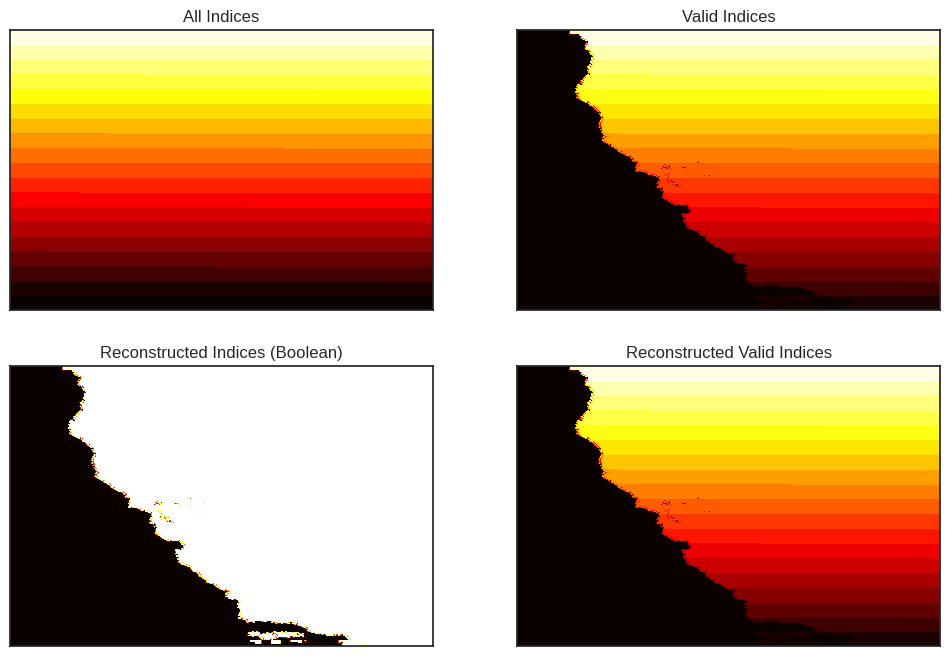

Module "plot_contours_of_indices" computing time: 1.0584700722247362 s


In [22]:
module_start_time = timer()
plot_contours_of_indices (data_at_timestamp, grid_indices_all, grid_indices_valid, \
                          grid_indices_valid_bool, grid_indices_valid_reconst, \
                          extracted_data_loc)
module_end_time = timer()
print('Module "plot_contours_of_indices" computing time: {} s'.format(module_end_time - module_start_time))

# Plot Quantities in the Selected Data File

## Plot the Contours of QoIs for the Data Just Read Above

In [23]:
qoi_to_plot = ['HGT', 'HGT_UPD', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

### Unmasked Data

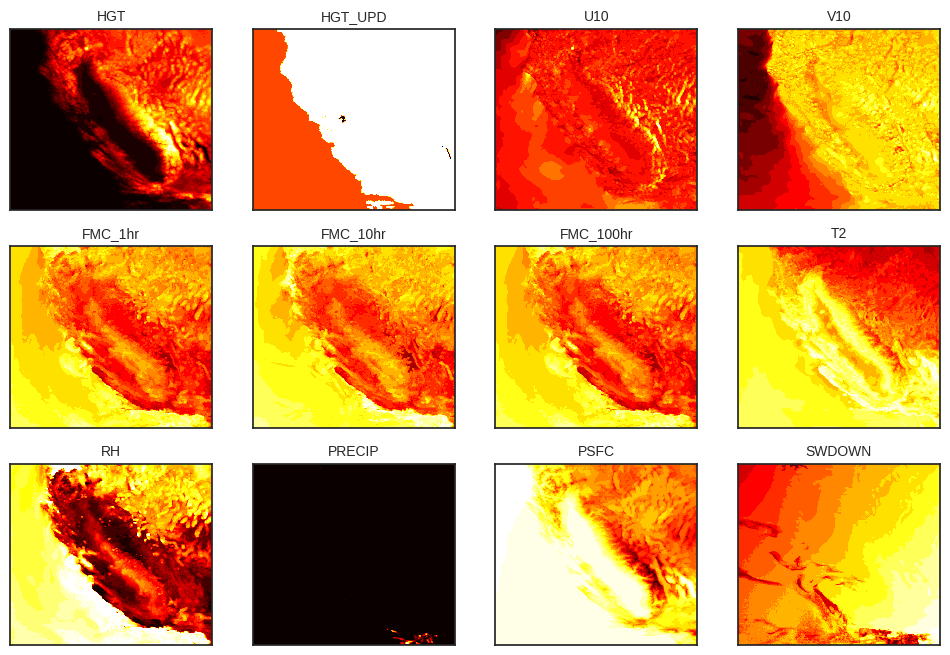

Module "plot_contours_at_timestamp" computing time: 4.7041791481897235 s


In [24]:
odule_start_time = timer()
plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, grid_indices_valid, masked = False)
module_end_time = timer()
print('Module "plot_contours_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

### Masked Data

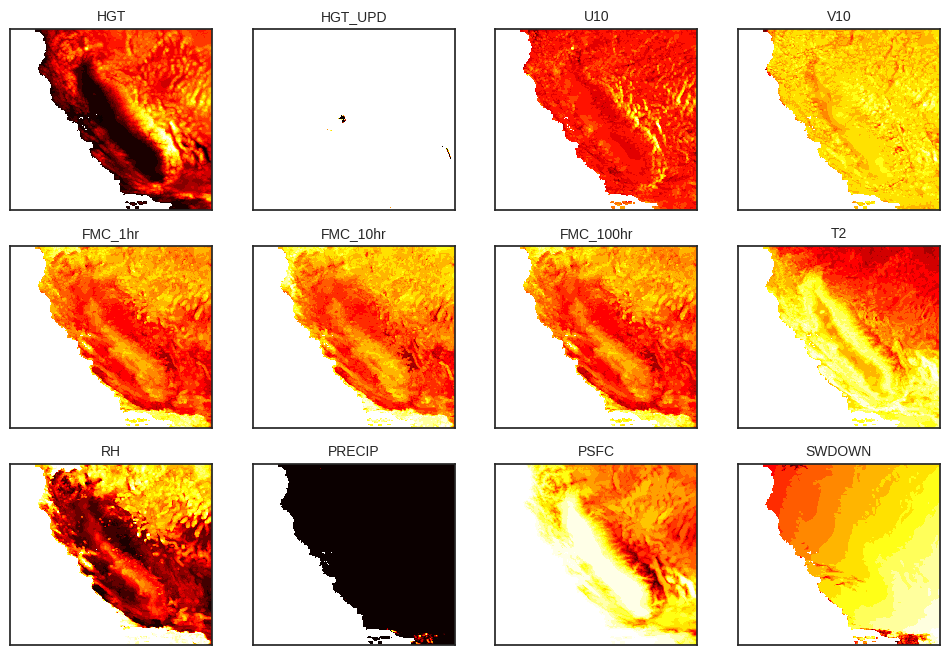

Module "plot_contours_at_timestamp" computing time: 3.4433630174025893 s


In [25]:
module_start_time = timer()
plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, grid_indices_valid, masked = True)
module_end_time = timer()
print('Module "plot_contours_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

## Plot the PDFs of QoIs for the Data Just Read Above

In [26]:
qoi_to_plot = ['HGT', 'Q2', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

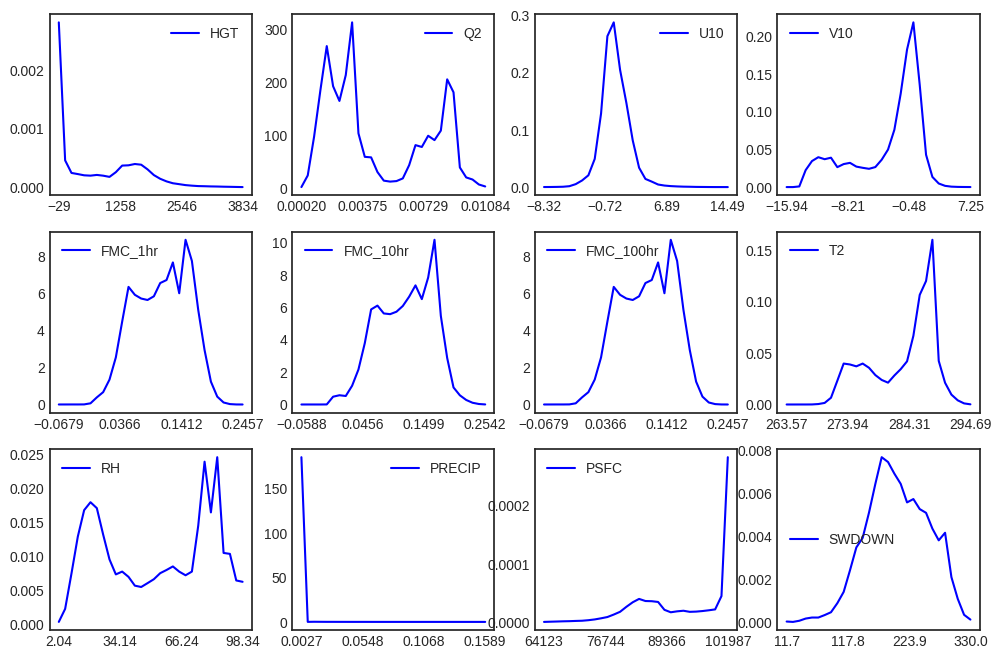

Module "plot_pdf_at_timestamp" computing time: 2.8517696214839816 s


In [27]:
module_start_time = timer()
plot_pdf_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc)
module_end_time = timer()
print('Module "plot_pdf_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

## Plot the Contours of QoIs With Colorbars

In [28]:
qoi_to_plot = qoi_to_plot = ['FMC_1hr', 'FMC_10hr', 'FMC_100hr']
cont_levels_count = 31

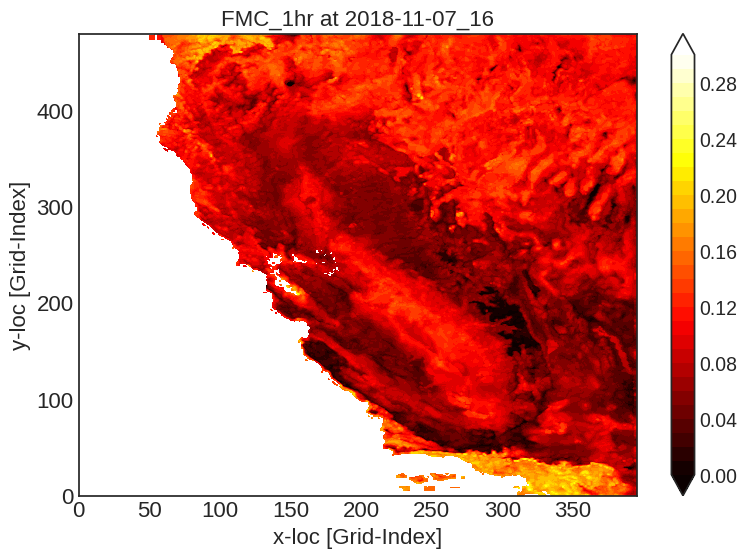

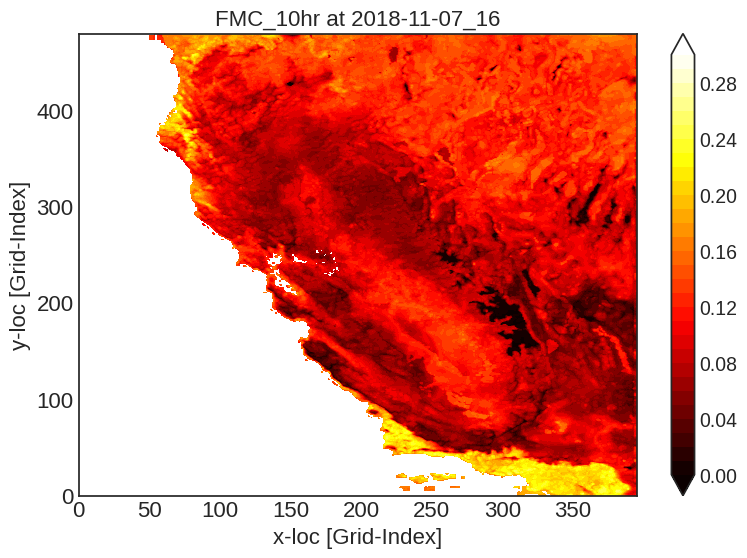

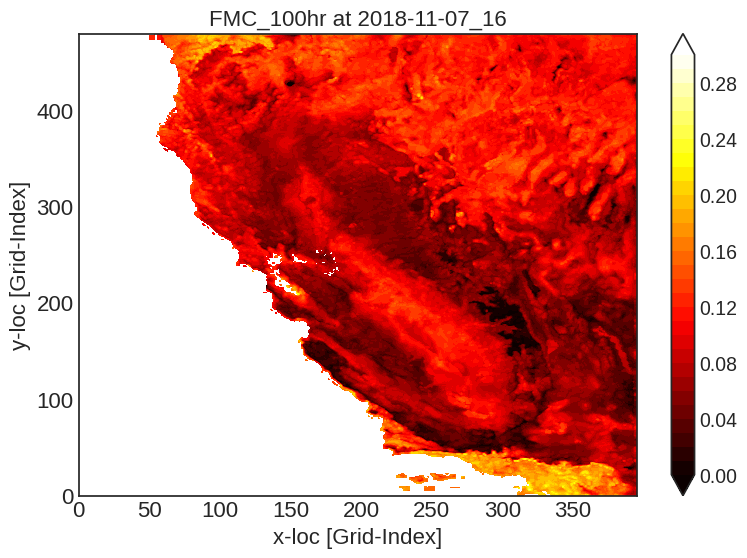

Module "plot_contours_at_timestamp2" computing time: 4.248033459298313 s


In [29]:
module_start_time = timer()
plot_contours_at_timestamp2 (data_at_timestamp, timestamp_to_read, qoi_to_plot, extracted_data_loc, grid_indices_valid, cont_levels_count, masked = True, qoi_cont_range = [0, 0.3])
#plot_contours_at_timestamp2 (data_at_timestamp, timestamp_to_read, qoi_to_plot, extracted_data_loc, grid_indices_valid, cont_levels_count, masked = True)
module_end_time = timer()
print('Module "plot_contours_at_timestamp2" computing time: {} s'.format(module_end_time - module_start_time))

# Sample and Plot Grid Indices for Each Sampled Ref Time

## Sample Grid Indices

In [30]:
module_start_time = timer()
grid_indices_selected, j_indices_selected, i_indices_selected = \
    sample_grid_indices (sampled_file_indices, percent_grid_points_to_use, \
                         grid_indices_valid_flat, valid_grid_ind_to_coord)
module_end_time = timer()
print('Module "sample_grid_indices" computing time: {} s'.format(module_end_time - module_start_time))

Selecting 13 grid points (approx 0.01 % of a total of 125316 considerable/valid grid points)

Module "sample_grid_indices" computing time: 0.20602790918201208 s


## Plot Sampled Grid Indices

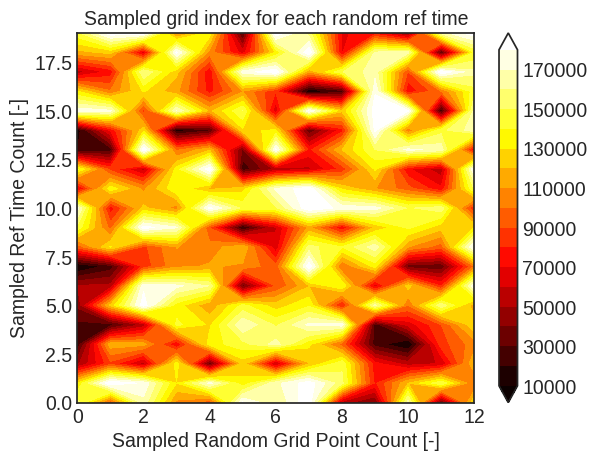

Module "plot_sampled_grid_points" computing time: 0.8103085597977042 s


In [31]:
module_start_time = timer()
plot_sampled_grid_points (grid_indices_selected, extracted_data_loc)
module_end_time = timer()
print('Module "plot_sampled_grid_points" computing time: {} s'.format(module_end_time - module_start_time))

## Plot Sampled Grid Indices in 3D

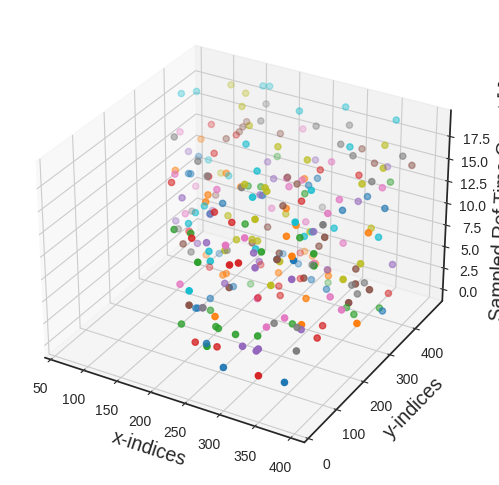

Module "plot_sampled_grid_points_3D" computing time: 0.7344293175265193 s


In [32]:
module_start_time = timer()
plot_sampled_grid_points_3D (j_indices_selected, i_indices_selected, extracted_data_loc, (6, 6))
module_end_time = timer()
print('Module "plot_sampled_grid_points_3D" computing time: {} s'.format(module_end_time - module_start_time))

# Create a Dict of Time Indices and Grid Indices

In [33]:
module_start_time = timer()
time_grid_indices_list_dict, time_grid_indices_list_count, time_grid_indices_set_dict, time_grid_indices_set_count = \
    create_time_grid_indices_map (sampled_file_indices, history_file_indices, grid_indices_selected)
module_end_time = timer()
print('Module "create_time_grid_indices_map" computing time: {} s'.format(module_end_time - module_start_time))

Module "create_time_grid_indices_map" computing time: 0.0004991879686713219 s


In [34]:
#len(time_grid_indices_list_dict.keys())

In [35]:
#len(time_grid_indices_set_dict.keys())

In [36]:
#time_grid_indices_list_dict
#time_grid_indices_list_count
#time_grid_indices_set_dict
#time_grid_indices_set_count

# Read Files At All Possible Time Indices (Ref + History)

## Read Data at All Times

In [37]:
module_start_time = timer()
file_indices_to_read, data_files_to_read, time_stamps_to_read, file_indices_data_dict = \
                read_data_all_possible_times (time_grid_indices_list_dict, data_files_list, \
                                             data_files_location)
module_end_time = timer()
print('Module "read_data_all_possible_times" computing time: {} s'.format(module_end_time - module_start_time))

Read a total of 100 files ( ref time + history)
Module "read_data_all_possible_times" computing time: 49.369643645361066 s


## Save Data In a Pickle File

In [38]:
module_start_time = timer()
save_data_read_at_all_possible_times (file_indices_to_read, data_files_to_read, \
                                      time_stamps_to_read, file_indices_data_dict, \
                                      extracted_data_loc, collection_of_read_data_files)
module_end_time = timer()
print('Module "save_data_read_at_all_possible_times" computing time: {} s'.format(module_end_time - module_start_time))

The picke file "dataset_00_files_read.pkl" already exists at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/dataset_00"
Module "save_data_read_at_all_possible_times" computing time: 0.0033103758469223976 s


## Read Data at All Possible Times Saved in a Pickle File

In [39]:
module_start_time = timer()
collection_of_read_data = read_data_from_pickle_all_possible_times (extracted_data_loc, \
                                                              collection_of_read_data_files)
module_end_time = timer()
print('Module "read_data_from_pickle_all_possible_times" computing time: {} s'.format(module_end_time - module_start_time))

Reading the picke file "dataset_00_files_read.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/dataset_00"
Module "read_data_from_pickle_all_possible_times" computing time: 2.506256867200136 s


In [40]:
#collection_of_read_data['file_indices_data_dict'].keys()

## Plot Data in a Few Files

In [41]:
qoi_to_plot = ['HGT', 'HGT_UPD', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

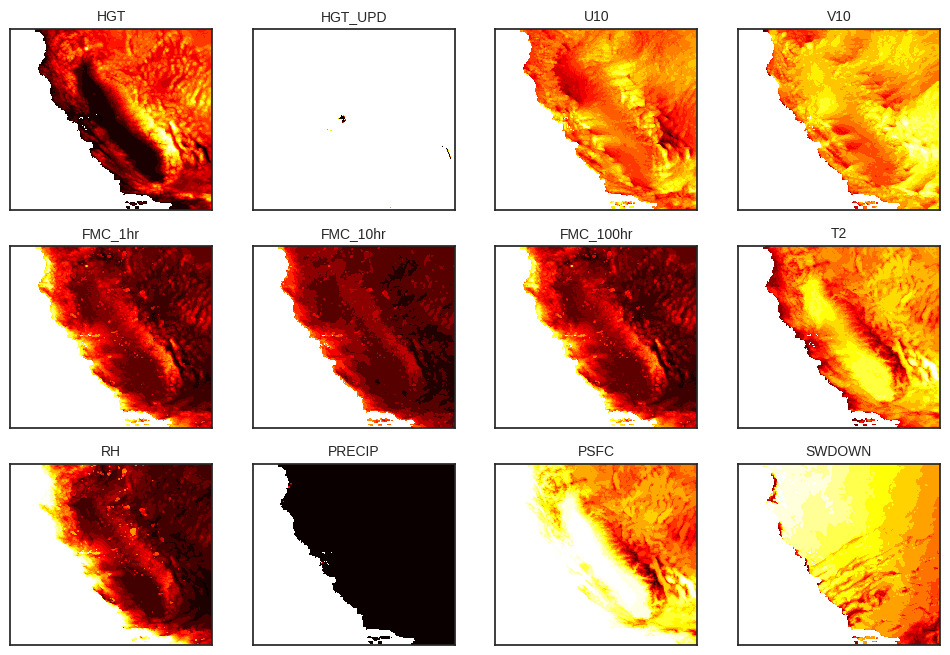

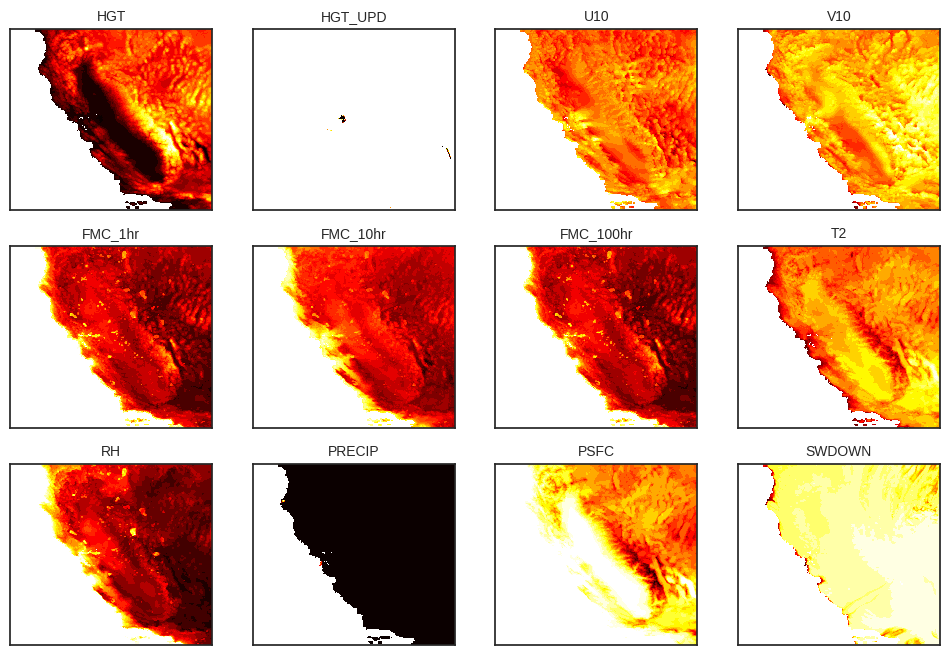

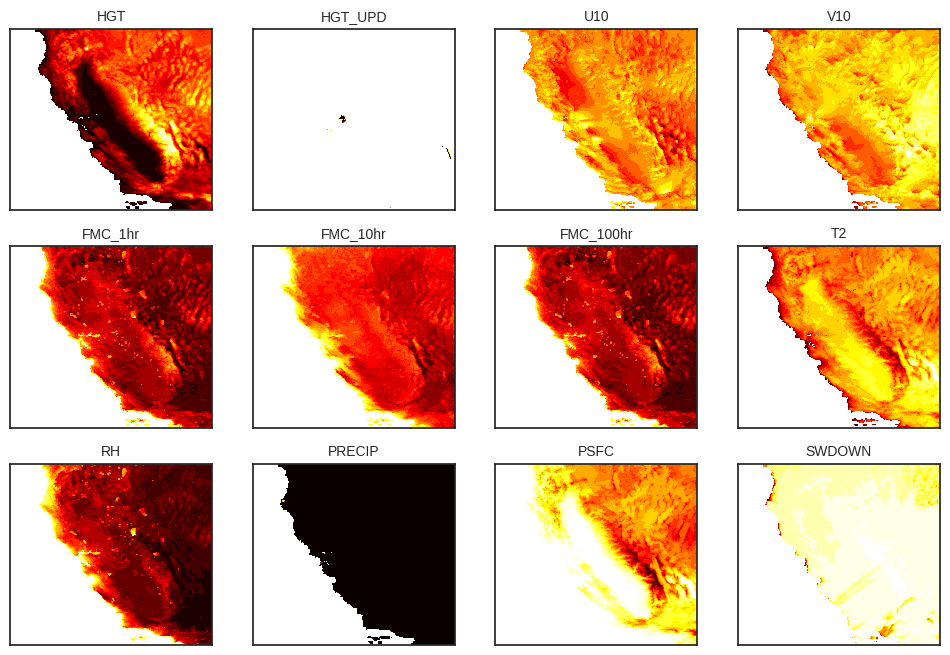

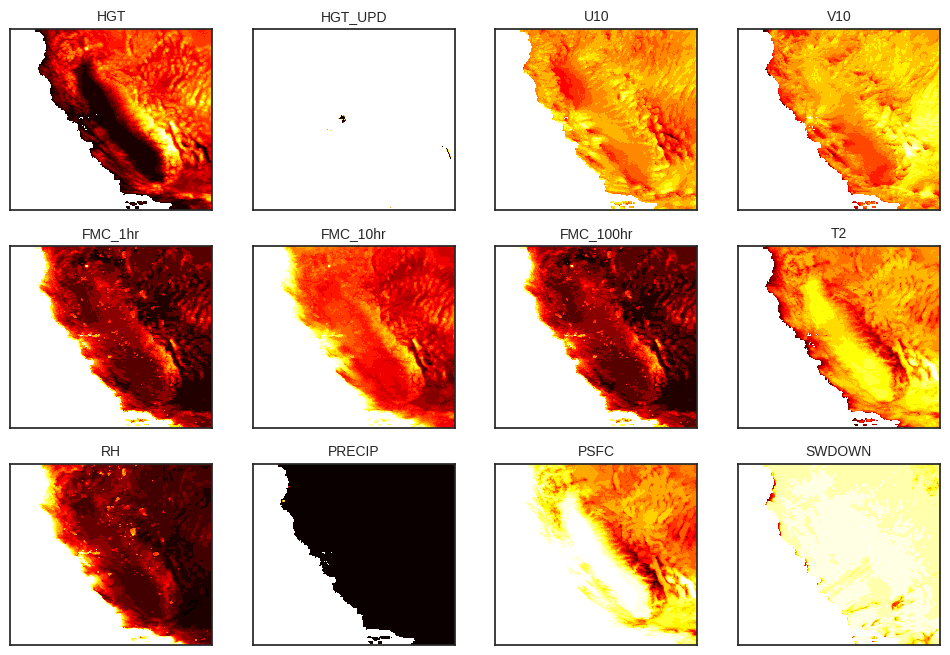

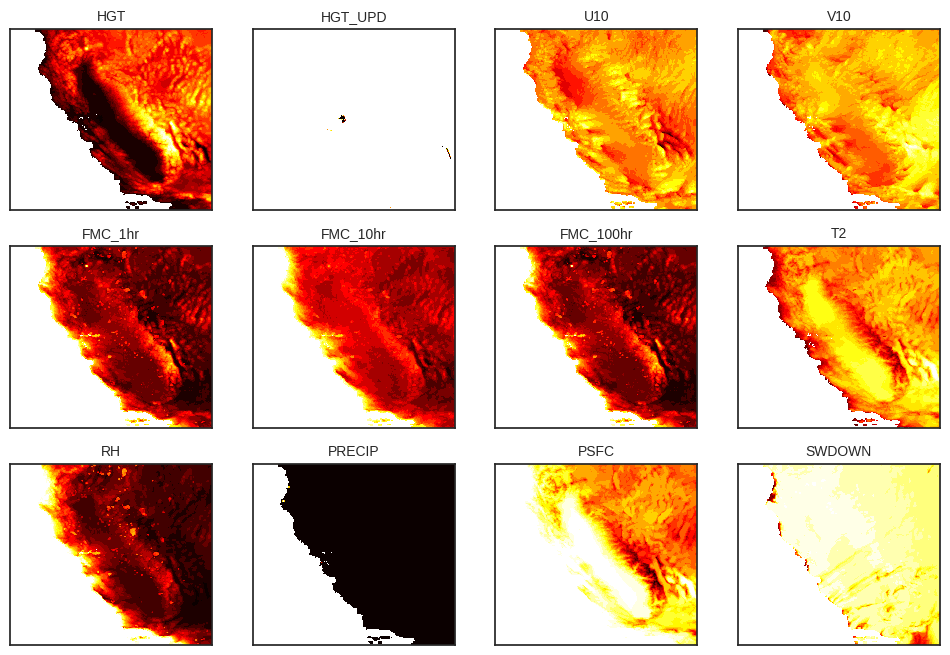

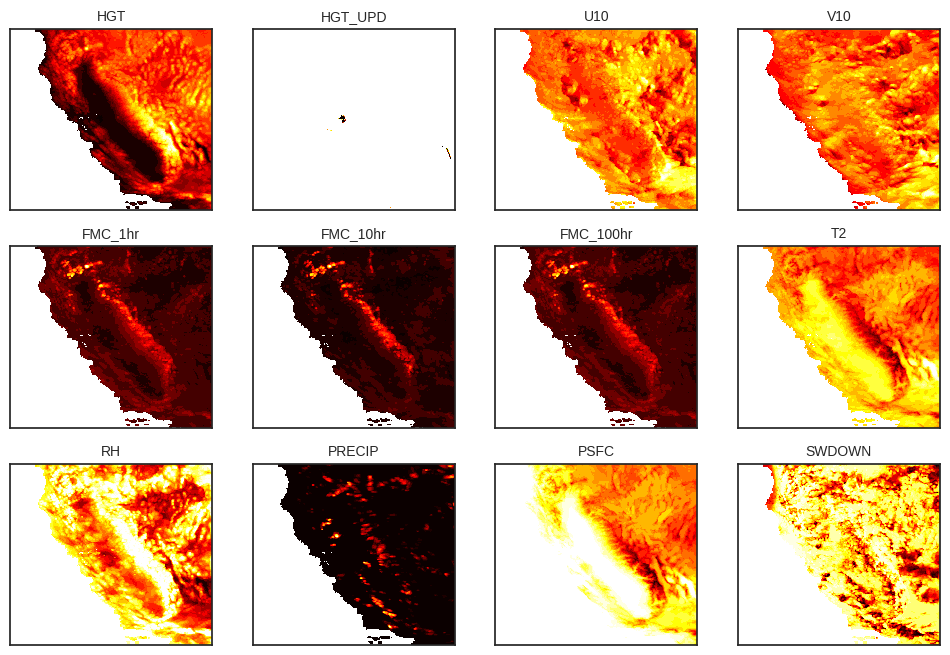

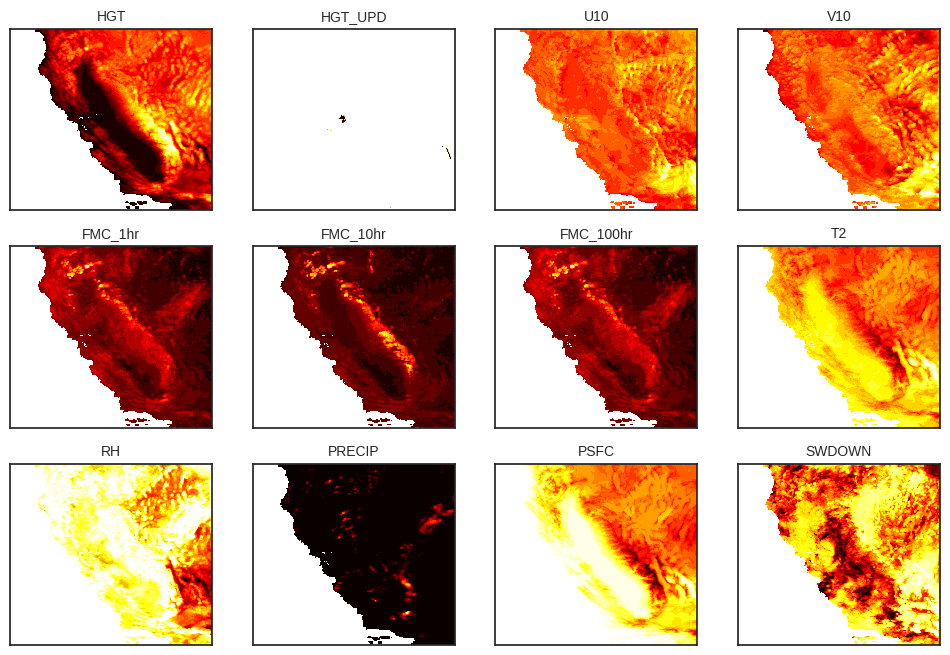

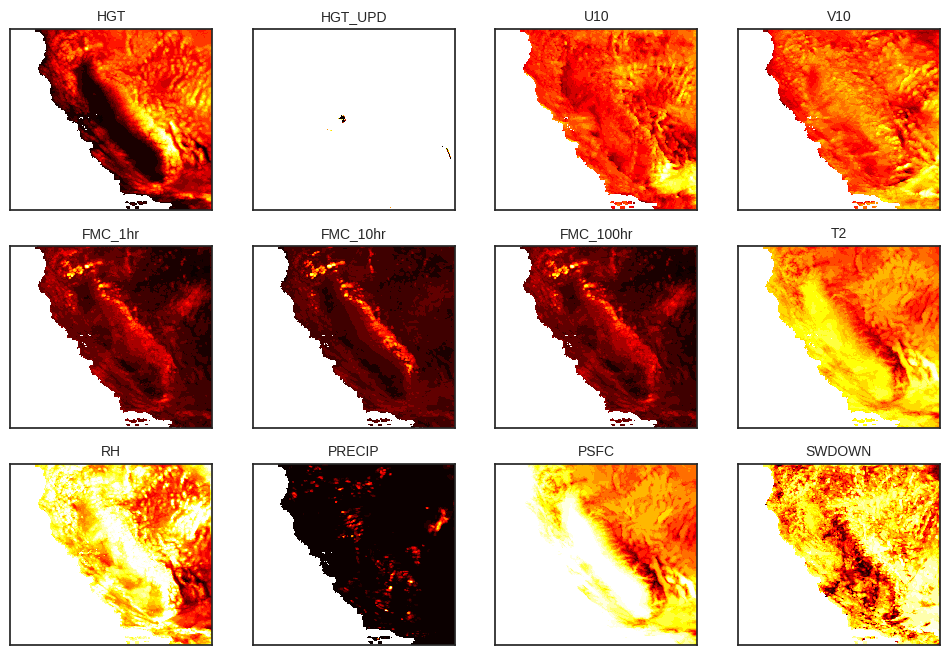

In [42]:
num_files = 8
file_indices_data_dict = collection_of_read_data['file_indices_data_dict']
file_indices_to_read = list(file_indices_data_dict.keys())
for file_index_to_read in file_indices_to_read[0:num_files]:
    data_at_timestamp = file_indices_data_dict[file_index_to_read]
    plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, \
                                grid_indices_valid, masked = True)

# Global End Time

In [43]:
global_end_time = timer()
print('Total computing time: {} s'.format(global_end_time - global_start_time))

Total computing time: 109.76905133016407 s


# Cells below this are old/legacy stuff for reference

# Grid Dimensions, Downsample Grid Points

In [ ]:
df_for_all_files = pd.DataFrame()
for file_count, data_file_name in enumerate(sampled_data_files):
    print ('\nReading data from file # {}, with name :- {}'.format(file_count, data_file_name))
    print('-----------------------------------------------------------------------')
    dfm_file_data = xr.open_dataset(path.join(data_files_location, data_file_name))
    
    df_for_single_file = downsample_grid_indices (data_file_name, dfm_file_data, percent_grid_points_to_use, 
                                                  max_history_to_consider, history_interval, frames_in_file)
    
    df_for_all_files = df_for_all_files.append(df_for_single_file).reset_index(drop = True)

In [ ]:
#df_for_all_files.head(10)

# Save the extracted data

In [ ]:
extracted_data = {'percent_files_to_use': [percent_files_to_use],
                 'percent_grid_points_to_use': [percent_grid_points_to_use],
                 'max_history_to_consider': [max_history_to_consider],
                 'history_interval': [history_interval],
                 'number_of_files_used' : [len(sampled_data_files)],
                 'number_of_data_points' : [len(df_for_all_files)],
                 'df_for_all_files': df_for_all_files}

In [ ]:
del extracted_data['df_for_all_files']
#extracted_data['index'] = 0

In [ ]:
tab_data_file_name = '{}.csv'.format(os.path.join(extracted_data_loc, data_set_name))
tabulated_data = pd.DataFrame.from_dict(extracted_data).reset_index(drop = True)
tabulated_data.to_csv(tab_data_file_name, index = False)